In [7]:
# preprocessing and vector extraction

In [6]:
from preprocessing import clean_text
from data_load import transform_vects
import vectorizers as vect
glove = vect.GloVeVectorizer(50)
data = open('./data/01_LOTR_Fellowship.txt')
data = data.read()
data = clean_text(data)
vectors = glove.vectorize(data[100:800])
ts, ys, white_noise = transform_vects(vectors, 1)

In [7]:
# importing for Hurst discovery
import os
import sys
# !pip install torch torchsde numpy seaborn matplotlib

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchsde
from fractional_neural_sde.fractional_noise import SparseGPNoise
from fractional_neural_sde.latent_sde import LatentSDE
from fractional_neural_sde.utils import LinearScheduler, manual_seed, plot_setting
from torch import distributions, optim
import data_load
adjoint = False
device = "cuda"
train_iters = 3000
kl_anneal_iters = 100
likelihood_cls = distributions.Laplace
scale = 0.025
method = "euler"
dt = 5 * 1e-3
batch_size = 50
seed = 0
device = torch.device(device if torch.cuda.is_available() else "cpu")

In [8]:
model = LatentSDE(white_noise).to(device)
sdeint_fn = torchsde.sdeint
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)
manual_seed(seed)

/Users/shayaanemran/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


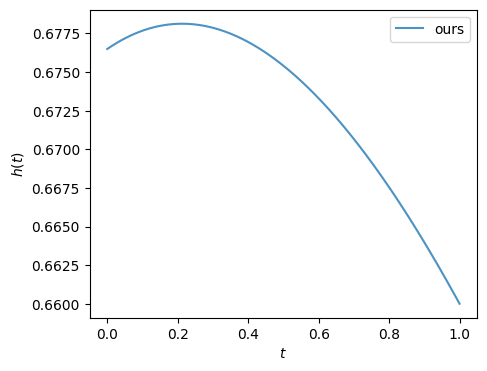

Iter: 0 	logpy: -41051.812 	kl: 1006.022 	loss: 41071.933


ValueError: Expected parameter loc (Parameter of shape (1, 1)) of distribution Normal(loc: Parameter containing:
tensor([[nan]], requires_grad=True), scale: tensor([[nan]], grad_fn=<ExpBackward0>)) to satisfy the constraint Real(), but found invalid values:
Parameter containing:
tensor([[nan]], requires_grad=True)

In [6]:
for i in range(100):
    optimizer.zero_grad()
    zs, kl = model(
        ts=ts, batch_size=batch_size, sdeint_fn=sdeint_fn, method=method, dt=dt
    )
    zs = zs.squeeze()
    zs = zs[1:-1]

    likelihood = likelihood_cls(loc=zs, scale=scale)
    logpy = likelihood.log_prob(ys[1:-1]).sum(dim=0).mean(dim=0)

    loss = (-logpy + kl * kl_scheduler.val).mean()
    loss.backward()

    optimizer.step()
    scheduler.step()
    kl_scheduler.step()
    if i % 10 == 0:
        plot_h(model.noise_path.compute_hurst, ts)
        plt.show()
        print(
            f"Iter: {i} \t"
            f"logpy: {logpy.detach().cpu().mean().numpy():.3f} \t"
            f"kl: {kl.cpu().detach().cpu().mean().numpy():.3f} \t"
            f"loss: {loss.cpu().detach().cpu().numpy():.3f}"
        )

In [ ]:
white_noise

In [225]:
ts.size()

torch.Size([50, 5])

In [252]:
kl

tensor(518.5743, grad_fn=<MeanBackward1>)

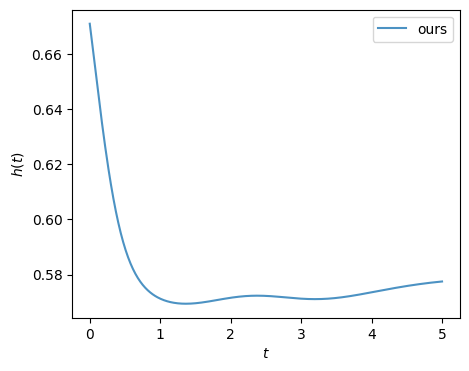

In [195]:
plot_h(model.noise_path.compute_hurst, ts)

In [5]:
def plot_h(hurst_fn, ts, shift=0.0):
    """Plot Hurst function"""
    plt.figure(figsize=(5, 4))

    with torch.no_grad():
        ht = hurst_fn(ts)

        plt.plot(ts - shift, ht, label="ours", alpha=0.8)
        plt.xlabel(r"$t$")
        plt.ylabel(r"$h(t)$")
        plt.legend()

In [231]:
torch.from_numpy(np.linspace(np.zeros(50)[0],np.full((1,50),1)[0],433)).size()

torch.Size([433, 50])

In [226]:
ys.size()

torch.Size([433, 1, 50])

In [235]:
torch.from_numpy(np.matrix(glove_data)).size()

torch.Size([433, 50])

In [3]:
ys

tensor([[[ 8.7943e-01, -1.1176e-01,  4.3380e-01,  ...,  3.7183e-01,
          -7.1368e-01,  3.0175e-01]],

        [[ 8.5692e-01,  1.1972e+00, -1.1754e+00,  ..., -3.4074e-01,
          -4.2359e-01, -2.6171e+00]],

        [[-8.2643e-01,  1.0991e+00, -1.1004e+00,  ...,  4.5312e-01,
          -3.7188e-01, -6.5143e-01]],

        ...,

        [[ 4.9861e-01, -1.2284e-01,  4.4772e-01,  ...,  2.6395e-01,
          -6.2214e-02,  6.2920e-01]],

        [[ 8.8387e-01, -1.4199e-01,  1.3566e-01,  ...,  5.2711e-01,
          -2.0148e-01,  9.5952e-03]],

        [[ 1.3153e+00, -2.3492e-02,  2.1741e-01,  ...,  9.6255e-01,
           4.5711e-01,  7.6767e-04]]], dtype=torch.float64)